In [1]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

api_key = "97OGHWS77V9ZH0G7"
ts = TimeSeries(key=api_key, output_format="pandas")

# Get daily historical data for Tesla
tesla, tesla_meta = ts.get_daily(symbol="TSLA", outputsize="full")
tesla.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-03-04,270.930,284.35,261.8401,272.04,125220232.0
2025-03-03,300.340,303.94,277.3000,284.65,115551414.0
2025-02-28,279.500,293.88,273.6000,292.98,115696968.0
2025-02-27,291.160,297.23,280.8800,281.95,101748197.0
2025-02-26,303.715,309.00,288.0400,290.80,100118276.0


In [2]:
'''import yfinance as yf

tesla = yf.Ticker('TSLA')
tesla = tesla.history(period="10y")  # last 30 years of data
tesla.to_csv('tesla.csv')
tesla.head()'''

'import yfinance as yf\n\ntesla = yf.Ticker(\'TSLA\')\ntesla = tesla.history(period="10y")  # last 30 years of data\ntesla.to_csv(\'tesla.csv\')\ntesla.head()'

In [3]:
# Load 4 datasets (3 will merge to make ESG dataset, 1 commodities metal dataset)
esg = pd.read_csv("data/ESG World Bank Data/esg_data.csv")
environ = pd.read_csv("data/World Bank Environmental Data/environment.csv", skiprows=3)
metals = pd.read_csv("data/Commodities IMF Data/commodities_IMF.csv")
carbon = pd.read_csv("data/ESG World Bank Data/global_carbon_prices.csv")

carbon.head()

,Category,Shanghai pilot ETS,Norway carbon tax,Sweden carbon tax,BC carbon tax,Tokyo CaT,California CaT,Japan carbon tax,UK Carbon Price Support,France carbon tax,Korea ETS,China national ETS,Canada federal fuel charge,Netherlands carbon tax,Germany ETS,UK ETS,Australia CPM,Ontario CaT
0,1991,0.0,86.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1992,0.0,118.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,1993,0.0,101.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,1994,0.0,99.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,1995,0.0,115.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [4]:
# Reshape the ESG data into a long format
esg = esg.drop(columns='Series Code')
esg = esg.rename(columns={'Series Name': 'Indicator Name'})
esg_long = esg.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name'],
    var_name='Year',
    value_name='Value'
)
# Clean the 'Year' column to extract the numeric year
esg_long['Year'] = esg_long['Year'].str.extract(r'(\d{4})')

# Replace '..' with NaN to ensure missing values are correctly identified
esg_long['Value'] = pd.to_numeric(esg_long['Value'], errors='coerce')
esg_long.replace('..', pd.NA, inplace=True)
esg_long = esg_long.dropna(subset=['Value'])

# Select only the relevant countries (US, UK, China, EU countries: Germany, France, Netherlands, Sweden, etc.)
relevant_countries = ['United States', 'United Kingdom', 'China', 'Germany', 'France', 'Norway', 'Canada', 'Japan', 'South Korea', 'Netherlands', 'Sweden', 'Australia']

# Filter the ESG data
esg_df = esg_long[esg_long['Country Name'].isin(relevant_countries)]

# Environment dataset processing
environ = environ.drop(columns='Indicator Code')
environ_long = environ.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name'],
    var_name='Year',
    value_name='Value'
)
# Replace '..' with NaN to ensure missing values are correctly identified
environ_long.replace('..', pd.NA, inplace=True)
environ_long = environ_long.dropna(subset=['Value'])

# Filter the Environmental data for the relevant countries
environ_df = environ_long[environ_long['Country Name'].isin(relevant_countries)]

# Print a summary of the filtered datasets
esg_df.head()
environ_df.head()

,Country Name,Country Code,Indicator Name,Year,Value
1973,Australia,AUS,Total fisheries production (metric tons),1960,6.134500e+04
1974,Australia,AUS,Capture fisheries production (metric tons),1960,5.564500e+04
1975,Australia,AUS,Aquaculture production (metric tons),1960,5.700000e+03
2035,Australia,AUS,"Electricity production from renewable sources,...",1960,1.412653e+00
2036,Australia,AUS,"Electricity production from renewable sources,...",1960,3.030000e+08


In [5]:
# For esg_df
esg_indicators = ['Political Stability and Absence of Violence/Terrorism: Estimate',
                  'Renewable electricity output (% of total electricity output)', 
                  'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)', 
                  'Research and development expenditure (% of GDP)', 'Gini index', 
                  'Methane emissions (metric tons of CO2 equivalent per capita)', 'Patent applications, residents',
                  'Net migration','Electricity production from coal sources (% of total)', 
                  'Renewable electricity output (% of total electricity output)', 
                  'Renewable energy consumption (% of total final energy consumption)',
                  'Population density (people per sq. km of land area)', 'GDP growth (annual %)', 'Regulatory Quality: Estimate'] 
# For environ_df
environ_indicators = ['Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)', 
                      'Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)',
                      'Methane (CH4) emissions from Transport (Energy) (Mt CO2e)']


In [6]:
# Filter the ESG data for relevant indicators
esg_df = esg_df[esg_df['Indicator Name'].isin(esg_indicators)]

# Filter the Environmental data for relevant indicators
environ_df = environ_df[environ_df['Indicator Name'].isin(environ_indicators)]

# Combine the ESG and Environmental datasets
combined_df = pd.concat([esg_df, environ_df], ignore_index=True)

# Sort the data for better readability
esg_df = combined_df.sort_values(by=['Country Name', 'Year', 'Indicator Name'])
esg_df

,Country Name,Country Code,Indicator Name,Year,Value
4719,Australia,AUS,Carbon dioxide (CO2) emissions from Transport ...,1970,32.479700
4720,Australia,AUS,Methane (CH4) emissions from Transport (Energy...,1970,0.299900
4718,Australia,AUS,Nitrous oxide (N2O) emissions from Transport (...,1970,0.405900
4752,Australia,AUS,Carbon dioxide (CO2) emissions from Transport ...,1971,33.373900
4753,Australia,AUS,Methane (CH4) emissions from Transport (Energy...,1971,0.315400
...,...,...,...,...,...
4716,United States,USA,Political Stability and Absence of Violence/Te...,2022,-0.036005
4717,United States,USA,Regulatory Quality: Estimate,2022,1.424440
6498,United States,USA,Carbon dioxide (CO2) emissions from Transport ...,2023,1710.645400
6499,United States,USA,Methane (CH4) emissions from Transport (Energy...,2023,3.615200


In [7]:
# Drop unnecessary columns
metals = metals.drop(columns=["Unnamed: 428", "Country Name", "Country Code", "Unit Code", "Attribute"], errors="ignore")

# Remove duplicates
metals = metals.drop_duplicates().reset_index(drop=True)

# Reshape Data to Long Format
metals = metals.melt(id_vars=["Commodity Name", "Commodity Code", "Unit Name"], 
                      var_name="Date", value_name="Value")

# Convert Date Column to datetime format
metals["Date"] = pd.to_datetime(metals["Date"].str.replace("M", "-", regex=False), format="%Y-%m")

# Handle missing values
metals = metals.dropna(subset=["Value"])

# Convert Value column to numeric
metals["Value"] = pd.to_numeric(metals["Value"], errors="coerce")

# Reset index after transformations
metals = metals.reset_index(drop=True)
metals

,Commodity Name,Commodity Code,Unit Name,Date,Value
0,Aluminum,PALUM,Index,1990-01-01,95.251042
1,Nickel,PNICK,Percent Change over Corresponding Period Previ...,1990-01-01,-60.192144
2,Nickel,PNICK,US Dollars,1990-01-01,7056.000000
3,Aluminum,PALUM,Percent Change over Previous Period,1990-01-01,-6.429884
4,Aluminum,PALUM,Percent Change over Corresponding Period Previ...,1990-01-01,-36.296876
...,...,...,...,...,...
3958,Aluminum,PALUM,Percent Change over Corresponding Period Previ...,2025-01-01,16.797308
3959,Aluminum,PALUM,US Dollars,2025-01-01,2571.370435
3960,Lithium,PLITH,US Dollars,2025-01-01,91267.271203
3961,Nickel,PNICK,Index,2025-01-01,160.226930


In [8]:
# Define name mapping excluding unwanted locations
name_map = {
    'Norway carbon tax': 'Norway - carbon tax',
    'Sweden carbon tax': 'Sweden - carbon tax',
    'France carbon tax': 'France - carbon tax',
    'China national ETS': 'China - ETS',
    'Canada federal fuel charge': 'Canada - ETS',
    'Netherlands carbon tax': 'Netherlands - carbon tax',
    'Germany ETS': 'Germany - ETS',
    'Australia CPM': 'Australia - ETS'
}

# Convert to long format
carbon_long = carbon.melt(id_vars=["Category"], var_name="Country_Indicator", value_name="Value")

# Apply name_map (rows with unmatched keys will become NaN)
carbon_long["Country_Indicator"] = carbon_long["Country_Indicator"].map(name_map)

# Drop rows that were mapped to NaN (i.e., the excluded locations)
carbon_long = carbon_long.dropna(subset=["Country_Indicator"])

# Split into 'Country Name' and 'Indicator Name', ensuring no extra spaces
carbon_long[['Country Name', 'Indicator Name']] = carbon_long['Country_Indicator'].str.rsplit('-', n=1, expand=True)
carbon_long["Country Name"] = carbon_long["Country Name"].str.strip()
carbon_long["Indicator Name"] = carbon_long["Indicator Name"].str.strip()

# Rename and clean up
carbon_long.rename(columns={"Category": "Year"}, inplace=True)
carbon_long.drop(columns=["Country_Indicator"], inplace=True)

# Display cleaned dataframe
carbon_long

,Year,Value,Country Name,Indicator Name
34,1991,86.88,Norway,carbon tax
35,1992,118.03,Norway,carbon tax
36,1993,101.12,Norway,carbon tax
37,1994,99.30,Norway,carbon tax
38,1995,115.81,Norway,carbon tax
...,...,...,...,...
539,2020,0.00,Australia,ETS
540,2021,0.00,Australia,ETS
541,2022,0.00,Australia,ETS
542,2023,0.00,Australia,ETS


In [9]:
# Cutting this dataset for now due to lack of countries recorded
# Drop 'Country Code' from the ESG dataset
# esg_df = esg_df.drop(columns=['Country Code'], errors='ignore')

# Combine the ESG dataset (all years) with the Carbon dataset (likely post-1991)
esg_df = pd.concat([esg_df, carbon_long], ignore_index=True)
esg_df

,Country Name,Country Code,Indicator Name,Year,Value
0,Australia,AUS,Carbon dioxide (CO2) emissions from Transport ...,1970,32.4797
1,Australia,AUS,Methane (CH4) emissions from Transport (Energy...,1970,0.2999
2,Australia,AUS,Nitrous oxide (N2O) emissions from Transport (...,1970,0.4059
3,Australia,AUS,Carbon dioxide (CO2) emissions from Transport ...,1971,33.3739
4,Australia,AUS,Methane (CH4) emissions from Transport (Energy...,1971,0.3154
...,...,...,...,...,...
6767,Australia,NaN,ETS,2020,0.0000
6768,Australia,NaN,ETS,2021,0.0000
6769,Australia,NaN,ETS,2022,0.0000
6770,Australia,NaN,ETS,2023,0.0000


In [10]:
esg_df.reset_index(drop=True)

,Country Name,Country Code,Indicator Name,Year,Value
0,Australia,AUS,Carbon dioxide (CO2) emissions from Transport ...,1970,32.4797
1,Australia,AUS,Methane (CH4) emissions from Transport (Energy...,1970,0.2999
2,Australia,AUS,Nitrous oxide (N2O) emissions from Transport (...,1970,0.4059
3,Australia,AUS,Carbon dioxide (CO2) emissions from Transport ...,1971,33.3739
4,Australia,AUS,Methane (CH4) emissions from Transport (Energy...,1971,0.3154
...,...,...,...,...,...
6767,Australia,NaN,ETS,2020,0.0000
6768,Australia,NaN,ETS,2021,0.0000
6769,Australia,NaN,ETS,2022,0.0000
6770,Australia,NaN,ETS,2023,0.0000


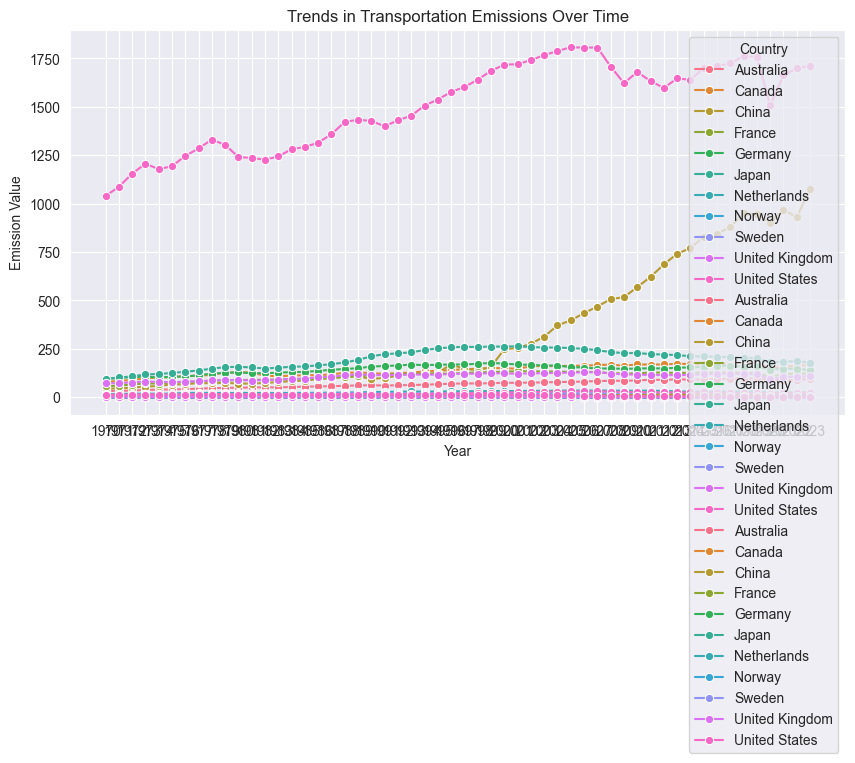

,count,mean,std,min,25%,50%,75%,max
Indicator Name,,,,,,,,
Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e),594.0,242.592330,426.726374,6.738400,32.094100,108.877000,162.076450,1.807722e+03
ETS,136.0,2.854853,10.046476,0.000000,0.000000,0.000000,0.000000,5.894000e+01
Electricity production from coal sources (% of total),462.0,33.783713,26.998523,0.015060,8.609056,28.612057,56.746471,8.400002e+01
GDP growth (annual %),539.0,2.852175,2.952463,-10.359901,1.502434,2.631000,4.043635,1.519154e+01
Gini index,301.0,32.689701,4.455026,22.900000,29.200000,32.500000,35.100000,4.370000e+01
Methane (CH4) emissions from Transport (Energy) (Mt CO2e),594.0,1.519048,2.887903,0.027400,0.180550,0.556550,1.098450,1.349210e+01
Methane emissions (metric tons of CO2 equivalent per capita),341.0,1.790266,1.883860,0.204206,0.785855,1.086874,2.127480,9.176355e+00
Net migration,517.0,157774.106383,380067.662297,-873177.000000,13425.000000,51268.000000,180746.000000,1.866819e+06
Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e),594.0,3.450209,6.381315,0.068400,0.272900,1.265150,2.059250,3.127280e+01


In [11]:
# Summary Statistics
import seaborn as sns
summary_stats = esg_df.groupby("Indicator Name")["Value"].describe()

# Plot trends for Carbon Emissions Indicators
plt.figure(figsize=(10, 5))
carbon_indicators = [
    "Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)",
    "Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)",
    "Methane (CH4) emissions from Transport (Energy) (Mt CO2e)",
]

for indicator in carbon_indicators:
    subset = esg_df[esg_df["Indicator Name"] == indicator]
    sns.lineplot(x="Year", y="Value", hue="Country Name", data=subset, marker="o")

plt.title("Trends in Transportation Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Emission Value")
plt.legend(title="Country")
plt.grid(True)
plt.show()

summary_stats

In [12]:
esg_indicators = [esg_df['Indicator Name'].unique()]
esg_indicators

[array(['Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)',
        'Methane (CH4) emissions from Transport (Energy) (Mt CO2e)',
        'Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)',
        'Electricity production from coal sources (% of total)',
        'GDP growth (annual %)', 'Net migration',
        'Population density (people per sq. km of land area)',
        'Patent applications, residents', 'Gini index',
        'Methane emissions (metric tons of CO2 equivalent per capita)',
        'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
        'Renewable electricity output (% of total electricity output)',
        'Renewable energy consumption (% of total final energy consumption)',
        'Political Stability and Absence of Violence/Terrorism: Estimate',
        'Regulatory Quality: Estimate',
        'Research and development expenditure (% of GDP)', 'carbon tax',
        'ETS'], dtype=object)]

In [13]:
tesla

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-03-04,270.930,284.3500,261.8401,272.04,125220232.0
2025-03-03,300.340,303.9400,277.3000,284.65,115551414.0
2025-02-28,279.500,293.8800,273.6000,292.98,115696968.0
2025-02-27,291.160,297.2300,280.8800,281.95,101748197.0
2025-02-26,303.715,309.0000,288.0400,290.80,100118276.0
...,...,...,...,...,...
2010-07-06,20.000,20.0000,15.8300,16.11,6866900.0
2010-07-02,23.000,23.1000,18.7100,19.20,5139800.0
2010-07-01,25.000,25.9200,20.2700,21.96,8218800.0


In [14]:
# Extract year from Tesla datetime index
tesla["year"] = tesla.index.year  
esg_df["Year"] = esg_df["Year"].astype(int)  

# Aggregate Tesla data by year (mean closing price and volume)
tesla_yearly = tesla.groupby("year").agg({"4. close": "mean", "5. volume": "mean"}).reset_index()

# Merge Tesla data with ESG data on Year
merged_data = tesla_yearly.merge(esg_df, left_on="year", right_on="Year")

# Dictionary to store correlations per indicator and country
correlation_results = {}

for country in esg_df['Country Name'].unique():
    country_data = merged_data[merged_data['Country Name'] == country]  # Filter for country

    for indicator in country_data['Indicator Name'].unique():
        subset = country_data[country_data["Indicator Name"] == indicator]  # Filter by indicator
        
        # Compute correlation only if there's enough data
        if subset[["4. close", "5. volume", "Value"]].dropna().shape[0] > 1:
            correlation_matrix = subset[["4. close", "5. volume", "Value"]].corr()
            correlation_results[(country, indicator)] = correlation_matrix.loc[["4. close", "5. volume"], "Value"]

# Convert results to a DataFrame with MultiIndex for better readability
correlation_df = pd.DataFrame(correlation_results).T.reset_index()
correlation_df.columns = ['Country', 'Indicator Name', '4. close', '5. volume']
correlation_df

,Country,Indicator Name,4. close,5. volume
0,Australia,Carbon dioxide (CO2) emissions from Transport ...,-0.178432,0.185695
1,Australia,Electricity production from coal sources (% of...,-0.905372,-0.822148
2,Australia,GDP growth (annual %),-0.368483,0.001055
3,Australia,Gini index,-0.483457,-0.235839
4,Australia,Methane (CH4) emissions from Transport (Energy...,-0.822201,-0.542437
...,...,...,...,...
179,United States,Population density (people per sq. km of land ...,0.876666,0.776205
180,United States,Regulatory Quality: Estimate,-0.001500,-0.055146
181,United States,Renewable electricity output (% of total elect...,0.734787,0.572125
182,United States,Renewable energy consumption (% of total final...,0.865930,0.783780


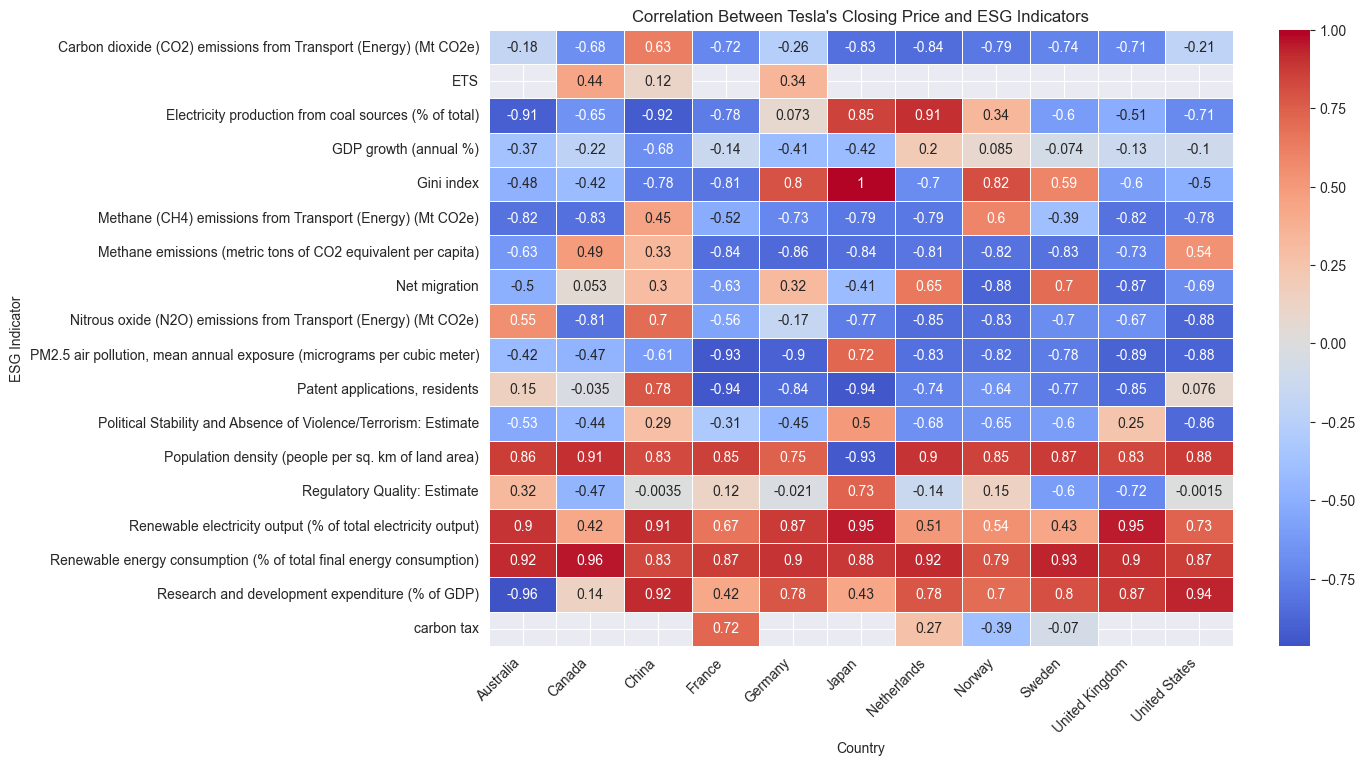

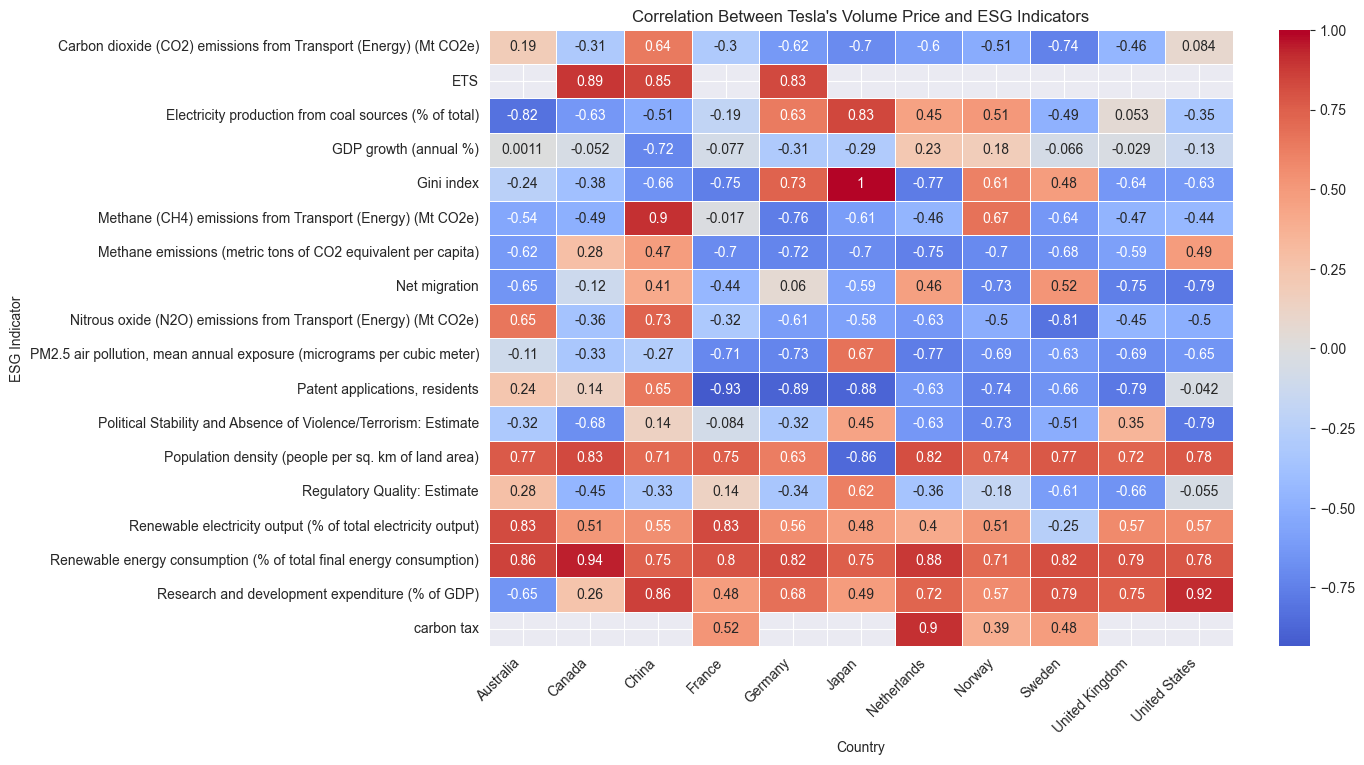

,Country,Indicator Name,Tesla Metric,Correlation
272,Japan,Gini index,5. volume,1.000000
88,Japan,Gini index,4. close,1.000000
15,Australia,Research and development expenditure (% of GDP),4. close,-0.964767
31,Canada,Renewable energy consumption (% of total final...,4. close,0.955506
98,Japan,Renewable electricity output (% of total elect...,4. close,0.949200
165,United Kingdom,Renewable electricity output (% of total elect...,4. close,0.948841
94,Japan,"Patent applications, residents",4. close,-0.944408
215,Canada,Renewable energy consumption (% of total final...,5. volume,0.943230
60,France,"Patent applications, residents",4. close,-0.941856
183,United States,Research and development expenditure (% of GDP),4. close,0.938513


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert correlation_df to a pivot table for heatmap visualization
heatmap_data = correlation_df.pivot(index="Indicator Name", columns="Country", values="4. close")

# Set up the figure for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Title and labels
plt.title("Correlation Between Tesla's Closing Price and ESG Indicators")
plt.xlabel("Country")
plt.ylabel("ESG Indicator")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

# Convert correlation_df to a pivot table for heatmap visualization
heatmap_data = correlation_df.pivot(index="Indicator Name", columns="Country", values="5. volume")

# Set up the figure for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Title and labels
plt.title("Correlation Between Tesla's Volume Price and ESG Indicators")
plt.xlabel("Country")
plt.ylabel("ESG Indicator")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

# Melt dataframe for better visualization
melted_corr = correlation_df.melt(id_vars=["Country", "Indicator Name"], 
                                  value_vars=["4. close", "5. volume"], 
                                  var_name="Tesla Metric", value_name="Correlation")

# Sort by highest absolute correlation values
top_corr = melted_corr.reindex(melted_corr["Correlation"].abs().sort_values(ascending=False).index).head(20)
top_corr

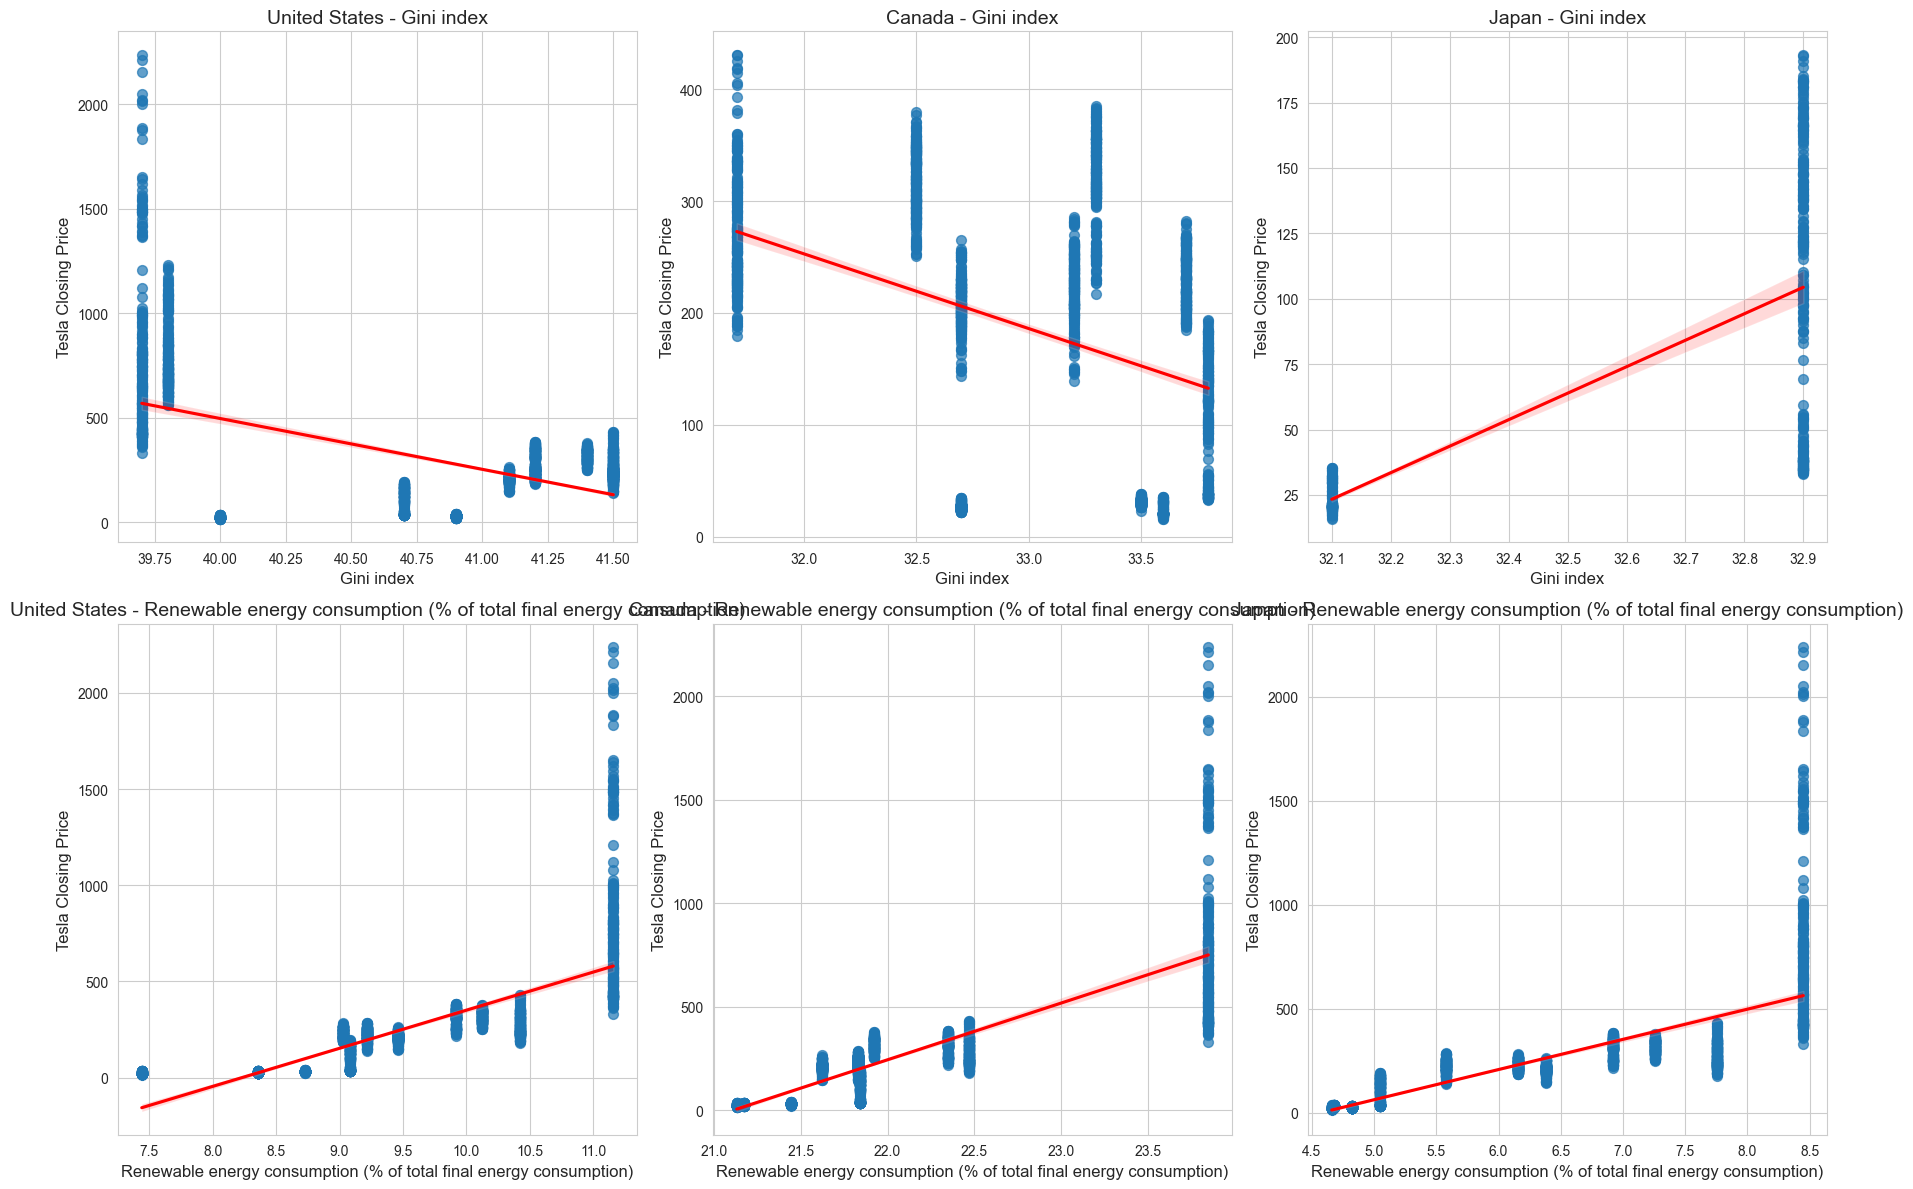

,1. open,2. high,3. low,4. close,5. volume,year,Country Name,Country Code,Indicator Name,Year,Value
0,699.99,718.7200,691.1200,705.67,49649928.0,2020,Japan,JPN,Renewable energy consumption (% of total final...,2020,8.45
1,672.00,696.6000,668.3603,694.78,42846021.0,2020,Japan,JPN,Renewable energy consumption (% of total final...,2020,8.45
2,661.00,669.9000,655.0000,665.99,22910811.0,2020,Japan,JPN,Renewable energy consumption (% of total final...,2020,8.45
3,674.51,681.4000,660.8000,663.69,31553561.0,2020,Japan,JPN,Renewable energy consumption (% of total final...,2020,8.45
4,642.99,666.0900,641.0000,661.77,22865568.0,2020,Japan,JPN,Renewable energy consumption (% of total final...,2020,8.45
...,...,...,...,...,...,...,...,...,...,...,...
2642,20.00,20.0000,15.8300,16.11,6866900.0,2010,Japan,JPN,Renewable energy consumption (% of total final...,2010,4.66
2643,23.00,23.1000,18.7100,19.20,5139800.0,2010,Japan,JPN,Renewable energy consumption (% of total final...,2010,4.66
2644,25.00,25.9200,20.2700,21.96,8218800.0,2010,Japan,JPN,Renewable energy consumption (% of total final...,2010,4.66
2645,25.79,30.4192,23.3000,23.83,17187100.0,2010,Japan,JPN,Renewable energy consumption (% of total final...,2010,4.66


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Define indicators and countries
indicators = ["Gini index", "Renewable energy consumption (% of total final energy consumption)"]
countries = ["United States", "Canada", "Japan"]

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Loop through each combination of indicator and country
for i, indicator in enumerate(indicators):
    for j, country in enumerate(countries):
        subset = esg_df[(esg_df['Indicator Name'] == indicator) & (esg_df['Country Name'] == country)]
        
        # Merge with Tesla stock data
        merged_df = tesla.merge(subset, left_on='year', right_on='Year', how="inner")

        # Create scatterplot with regression line
        sns.regplot(x=merged_df['Value'], y=merged_df['4. close'], ax=axes[i, j], scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red'})
        
        # Set titles and labels
        axes[i, j].set_title(f"{country} - {indicator}", fontsize=14)
        axes[i, j].set_xlabel(indicator, fontsize=12)
        axes[i, j].set_ylabel("Tesla Closing Price", fontsize=12)

plt.tight_layout()
plt.show()
merged_df

In [17]:
# Assuming df is your original DataFrame
esg_pivot = esg_df.pivot_table(index=["Country Name", "Country Code", "Year"], 
                          columns="Indicator Name", 
                          values="Value").reset_index()
esg_pivot = esg_pivot[esg_pivot["Year"] >= 2010]

esg_pivot.columns.name = None  # Remove the automatic column name
#esg_pivot = esg_pivot.drop(columns=['Country Code', 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)', 'Methane emissions (metric tons of CO2 equivalent per capita)'])
# Dropped PM2.5 and Methane emissions predictors due to missing values
nan_counts_before = esg_pivot.isna().sum()
nan_counts_before

Country Name                                                               0
Country Code                                                               0
Year                                                                       0
Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)           0
Electricity production from coal sources (% of total)                     88
GDP growth (annual %)                                                     11
Gini index                                                                47
Methane (CH4) emissions from Transport (Energy) (Mt CO2e)                  0
Methane emissions (metric tons of CO2 equivalent per capita)              33
Net migration                                                             33
Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)            0
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)    44
Patent applications, residents                                            22

In [18]:
esg_ffill = esg_pivot.ffill()
esg_ffill

,Country Name,Country Code,Year,Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e),Electricity production from coal sources (% of total),GDP growth (annual %),Gini index,Methane (CH4) emissions from Transport (Energy) (Mt CO2e),Methane emissions (metric tons of CO2 equivalent per capita),Net migration,Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e),"PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)","Patent applications, residents",Political Stability and Absence of Violence/Terrorism: Estimate,Population density (people per sq. km of land area),Regulatory Quality: Estimate,Renewable electricity output (% of total electricity output),Renewable energy consumption (% of total final energy consumption),Research and development expenditure (% of GDP)
40,Australia,AUS,2010,87.6345,71.327642,2.226538,34.7,0.2926,5.873901,166833.0,1.2829,6.785236,2409.0,0.888860,2.867859,1.695977,8.611880,8.16,2.37075
41,Australia,AUS,2011,89.7726,67.988279,2.408972,34.7,0.2750,7.949702,197748.0,1.2768,6.707495,2383.0,0.935710,2.907986,1.852123,10.426652,8.32,2.23484
42,Australia,AUS,2012,90.4324,68.554964,3.918410,34.7,0.2650,7.776994,235719.0,1.3155,6.995491,2627.0,0.997997,2.959200,1.778897,10.592653,8.30,2.23484
43,Australia,AUS,2013,91.8340,63.715393,2.606198,34.7,0.2502,6.091448,214564.0,1.3422,6.964302,3061.0,1.031073,3.010574,1.791220,13.264108,9.22,2.17843
44,Australia,AUS,2014,92.0252,61.164325,2.607401,34.4,0.2390,6.565353,198120.0,1.3365,6.880051,1988.0,1.032192,3.055815,1.857373,14.906712,9.33,2.17843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,United States,USA,2019,1757.3448,34.232734,2.294439,41.5,3.7215,2.389355,1158444.0,22.4755,7.663693,285113.0,0.117877,35.893176,1.334575,13.228593,10.42,3.17049
590,United States,USA,2020,1507.9152,34.232734,-2.767803,39.7,3.2385,2.257060,675560.0,19.2081,7.663693,269586.0,-0.026929,36.240985,1.238438,13.228593,11.16,3.46777
591,United States,USA,2021,1663.6783,34.232734,5.945485,39.8,3.5505,2.257060,675560.0,20.9738,7.663693,262244.0,-0.014878,36.297836,1.440957,13.228593,11.16,3.45705
592,United States,USA,2022,1699.4280,34.232734,1.935635,39.8,3.5976,2.257060,675560.0,21.3674,7.663693,262244.0,-0.036005,36.297836,1.424440,13.228593,11.16,3.45705


In [19]:
metals["Date"] = pd.to_datetime(metals["Date"])
tesla.index = pd.to_datetime(tesla.index)

# Filter metals data to keep only "US Dollars" (actual prices)
for measure in metals['Unit Name'].unique():
    metals_price_df = metals[metals["Unit Name"] == measure]

    # Pivot metals data to have commodities as columns, indexed by Date
    metals_pivot = metals_price_df.pivot(index="Date", columns="Commodity Name", values="Value")

    # Align Tesla data with metals data on Date
    tesla_daily = tesla[["4. close", "5. volume"]].copy()
    merged_daily = tesla_daily.merge(metals_pivot, left_index=True, right_index=True, how="inner")

    # Compute correlation coefficients
    correlation_results_metals = merged_daily.corr().loc[["4. close", "5. volume"]]

    # Display only metal correlations
    correlation_df_metals = correlation_results_metals.drop(["4. close", "5. volume"], axis=1)
    print(f'{measure}: \n{correlation_df_metals}\n')

Index: 
           Aluminum   Lithium   Nickel 
4. close   0.317612  0.342692  0.102506
5. volume  0.273195  0.422781  0.288460

Percent Change over Corresponding Period Previous Year: 
           Aluminum   Lithium   Nickel 
4. close   0.442897  0.547378  0.427506
5. volume -0.163836 -0.171763 -0.184469

US Dollars: 
           Aluminum   Lithium   Nickel 
4. close   0.317612  0.342692  0.102506
5. volume  0.273195  0.422781  0.288460

Percent Change over Previous Period: 
           Aluminum   Lithium   Nickel 
4. close   0.117919  0.404274  0.167283
5. volume -0.049756 -0.242189 -0.092937


In [28]:
tesla_esg = tesla_yearly.merge(esg_ffill, left_on="year", right_on="Year")
tesla_esg = tesla_esg.drop(['year'], axis=1).drop(['Year'], axis=1).drop(['5. volume'], axis=1)
tesla_esg

,4. close,Country Name,Country Code,Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e),Electricity production from coal sources (% of total),GDP growth (annual %),Gini index,Methane (CH4) emissions from Transport (Energy) (Mt CO2e),Methane emissions (metric tons of CO2 equivalent per capita),Net migration,Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e),"PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)","Patent applications, residents",Political Stability and Absence of Violence/Terrorism: Estimate,Population density (people per sq. km of land area),Regulatory Quality: Estimate,Renewable electricity output (% of total electricity output),Renewable energy consumption (% of total final energy consumption),Research and development expenditure (% of GDP)
0,23.341723,Australia,AUS,87.6345,71.327642,2.226538,34.7,0.2926,5.873901,166833.0,1.2829,6.785236,2409.0,0.888860,2.867859,1.695977,8.611880,8.16,2.37075
1,23.341723,Canada,CAN,169.4329,13.172180,3.090806,33.6,0.8452,2.534203,227724.0,2.2358,7.884019,4550.0,0.936318,3.792822,1.693430,61.396757,21.13,1.82528
2,23.341723,China,CHN,568.7798,77.187194,10.635871,43.7,4.5609,0.796622,-216417.0,11.6115,53.286677,293066.0,-0.657061,142.487743,-0.320955,18.622826,12.26,1.71372
3,23.341723,France,FRA,123.2710,4.663424,1.949438,33.7,0.1998,1.040939,86355.0,1.1567,15.076985,14748.0,0.681088,118.764941,1.310161,13.857359,11.99,2.17857
4,23.341723,Germany,DEU,148.1233,43.642422,4.179882,30.3,0.3344,0.707258,267047.0,1.4058,16.089344,47047.0,0.796834,234.606908,1.570686,16.727074,11.61,2.73024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,217.475240,Netherlands,NLD,25.4901,38.653584,4.328918,25.7,0.0651,0.871518,58816.0,0.2261,12.039286,2080.0,0.717305,520.731928,1.712272,12.442082,10.79,2.30886
150,217.475240,Norway,NOR,13.4938,0.104918,3.015889,27.7,0.0370,0.807283,10756.0,0.1184,6.642383,946.0,0.860958,14.847009,1.516140,97.709871,61.29,1.93798
151,217.475240,Sweden,SWE,13.3122,0.666951,2.911772,29.8,0.0574,0.462850,81066.0,0.1333,5.647573,1771.0,0.902623,25.573857,1.681577,63.262748,58.40,3.41743
152,217.475240,United Kingdom,GBR,108.4809,22.806491,4.346561,32.4,0.1277,0.751562,211063.0,1.1418,10.092844,11592.0,0.503939,277.048287,1.566510,24.840050,13.50,2.91476


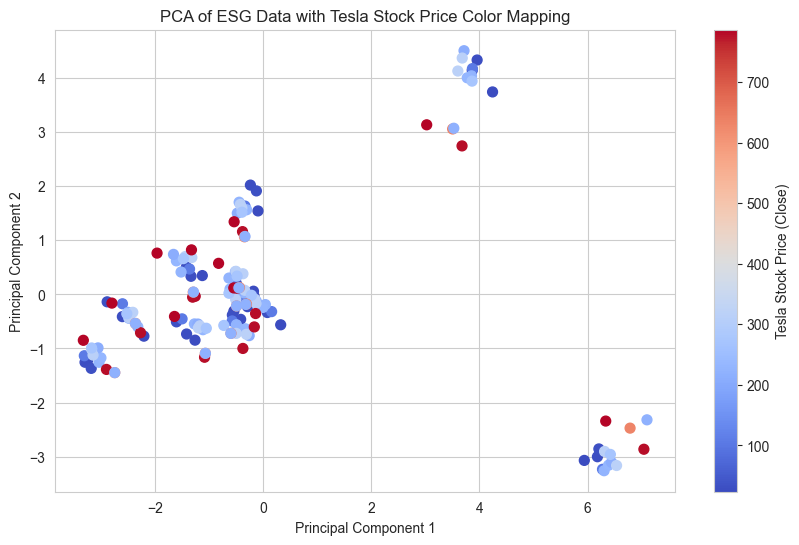

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop categorical columns and '4. close'
esg_data = tesla_esg.drop(['Country Name', 'Country Code', '4. close'], axis=1)

# Standardize the data
scaler = StandardScaler()
esg_data_scaled = scaler.fit_transform(esg_data)

# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(esg_data_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Add Tesla stock price ('4. close') to the PCA DataFrame
pca_df['Stock Price'] = tesla_esg['4. close']

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Stock Price'], cmap='coolwarm', s=50)
plt.colorbar(label='Tesla Stock Price (Close)')  # Colorbar to show the scale of stock price
plt.title('PCA of ESG Data with Tesla Stock Price Color Mapping')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

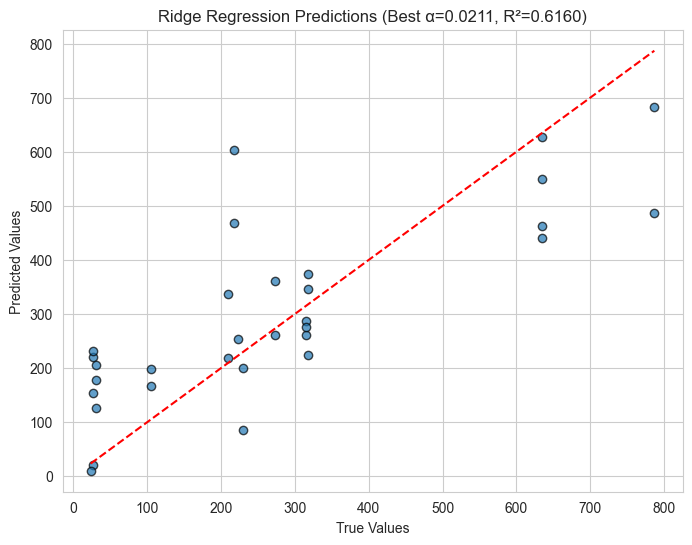

(np.float64(0.021102034285685942), np.float64(0.6159535335742872))

In [21]:
# Implement Ridge Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

tesla_esg = tesla_esg.drop(columns=['Country Code'])

# Define the target and features
target = "4. close"
y = tesla_esg[target]
X = tesla_esg.drop(columns=[target])

# Identify categorical and numerical columns
categorical_features = ["Country Name"]
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)])

# Apply transformation
X = preprocessor.fit_transform(X)

# Get feature names after transformation
num_feature_names = numerical_features
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = num_feature_names + list(cat_feature_names)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over 1000 alphas to optimize R²
alphas = np.logspace(-4, 2, 1000)
best_r2 = -np.inf
best_alpha = None
best_model = None

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha
        best_model = model

# Predict with the best model
y_pred_best = best_model.predict(X_test)

# Scatter plot of predicted vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7, edgecolors="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Ridge Regression Predictions (Best α={best_alpha:.4f}, R²={best_r2:.4f})")
plt.show()

best_alpha, best_r2

In [22]:
# Extract coefficients
ridge_coefficients = best_model.coef_

# Create DataFrame of coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefficients})
coeff_df = coeff_df.sort_values(by="Coefficient", ascending=False)

# Display results
print(f"Best Alpha: {best_alpha:.4f}")
print(f"Best R²: {best_r2:.4f}")
print("\nFeature Coefficients:")
print(coeff_df)

Best Alpha: 0.0211
Best R²: 0.6160

Feature Coefficients:
                                              Feature  Coefficient
25                         Country Name_United States  1286.838804
14  Renewable energy consumption (% of total final...  1013.338454
17                                 Country Name_China   782.191209
7   Nitrous oxide (N2O) emissions from Transport (...   689.759077
20                                 Country Name_Japan   275.065617
1   Electricity production from coal sources (% of...   199.751168
21                           Country Name_Netherlands   162.865749
12                       Regulatory Quality: Estimate   122.672763
15    Research and development expenditure (% of GDP)   109.705991
8   PM2.5 air pollution, mean annual exposure (mic...   105.839427
16                                Country Name_Canada    98.999125
24                        Country Name_United Kingdom    83.356365
9                      Patent applications, residents     2.749273
2   

In [23]:
len(tesla_esg.drop(columns=[target]).columns)

17

In [24]:
len(ridge_coefficients)

26